### Add tuning

# Synthetic dataset creation

In this notebook I create a synthetic dataset to test the proposed bandit algorithm and compare it to benchmarks.
Synthetic dataset will have following features:
- 10,000 time points
- At each time $t$ the environment generates a context vector $x_t$ of dimension 6. Each feature $x_t^{(i)}$ is **categorical**, and lies in range(1,feature_size). This is needed for the `state_extract` function in SimOOS to correctly number all the states.
- Each context vector $x_t$ is associated with a cost vector $c_t$. Cost of each feature $c_t^{i}$ follows a Gaussian distribution with fixed standard deviation and **piecewise-constant** mean lying in range $[0; 0.04]$. Change-points of costs are different from change points of rewards.
- A fixed (for all $t$) set $\mathcal{A}$ of 5 arms are available for the algorithm to choose from.
- Rewards associated with each arm and context follow a Bernoulli distribution, parametrized by $p = \sigma(\bar{x_t}^T\theta_{t,a})$. Here $\bar{x_t}$ is not context observed at time t, but rather it is expected context inside one stationarity interval.  Also $\sigma()$ is the sigmoid function and $\theta_{t,a}$ is the ground truth bandit parameter (not disclosed to the algorithm) associated with each arm $a_i$ at time $t$. Bandit parameter satisfies condition $\lVert\theta_{t,a}\rVert_2 \le 1$.  For each arm $a_i$, parameter $\theta_{t,a}$ is piecewise-constant and thus the corresponding **generating process of rewards is piecewise-stationary** with change points every 2000 steps.
This method of generating rewards from contexts follows [1] and [2], but instead of Gaussian reward with mean $x_t^T\theta_{t,a}$ the reward is Bernoulli with parameter $\sigma(\bar{x_t}^T\theta_{t,a})$

[1] Learning Contextual Bandits in a Non-stationary Environment, Wu et al.

[2] Contextual-Bandit Based Personalized Recommendation with Time-Varying User Interests, Xu et al.

In [1]:
import os
os.chdir('../..')
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import time
import math

import costs
from plotting.costs import plot_costs

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)

#### Setting important constants

In [4]:
TIME_POINTS = 10000
NUM_FEATURES = 5
N_ARMS = 5

## Creating context vectors

In [5]:
def categorical(values, distribution, length):
    assert len(values) == len(distribution)
    values = np.array(values)
    sample = np.random.multinomial(1, distribution, size=(length,))
    indices = np.argmax(sample, axis=1)
    return values[indices]

In [6]:
values = [5,6,7,120]
distribution = [0.2, 0.1, 0.4, 0.3]
categorical(values, distribution, length=7)

array([  6,   7, 120,   7,   5,   5,   7])

In [7]:
feature_config = {
    0: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    1: {
        'values': [1, 2],
        'distribution': [0.2, 0.8],
    },
    2: {
        'values': [1, 2, 3],
        'distribution': [ 0.6, 0.3, 0.1],
    },
    3: {
        'values': [1,2,3,4],
        'distribution': [0.1, 0.2, 0.3, 0.4],
    },
    
    4: {
        'values': [1,2,3,4,5],
        'distribution': [0.15, 0.2, 0.3, 0.2, 0.15],
    },
    5: {
        'values': [1,2],
        'distribution': [0.1, 0.9],
    },
    6: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    7: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    8: {
        'values': [1,2,3,4],
        'distribution': [0.4, 0.3, 0.2, 0.1],
    },
    9: {
        'values': [1, 2,3,4,5,6,7,8,9,10,11],
        'distribution': [0.01, 0.03, 0.08, 0.12, 0.16, 0.20, 0.16, 0.12 ,0.08, 0.03, 0.01],
    },
}

In [8]:
contexts = np.zeros((TIME_POINTS, NUM_FEATURES))

for i in range(NUM_FEATURES):
    values = feature_config[i]['values']
    distribution = feature_config[i]['distribution']
    contexts[:, i] = categorical(values, distribution, length=TIME_POINTS)

In [9]:
contexts, contexts.shape

(array([[4., 2., 2., 4., 4.],
        [4., 2., 1., 3., 4.],
        [4., 1., 1., 3., 5.],
        ...,
        [2., 2., 1., 4., 2.],
        [1., 2., 1., 4., 3.],
        [2., 2., 1., 4., 5.]]),
 (10000, 5))

### Visualizing context features

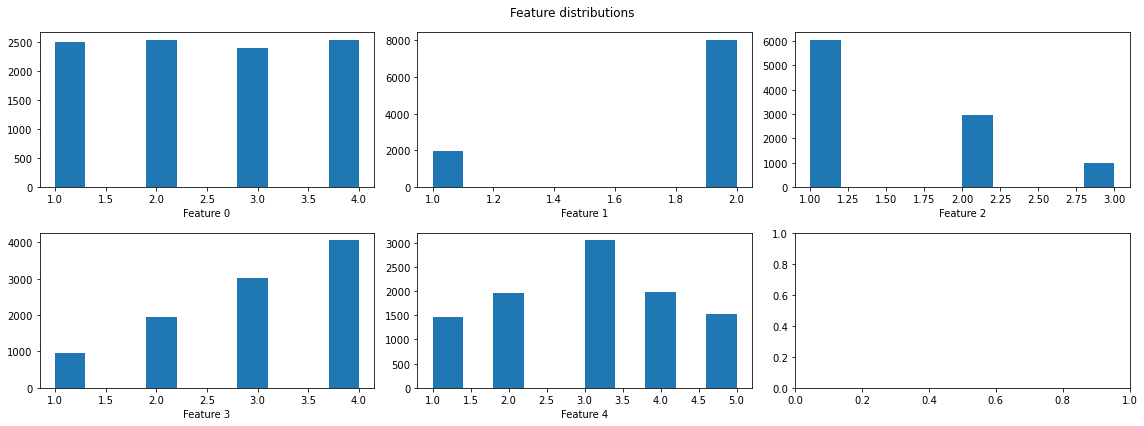

In [10]:
fig, axs = plt.subplots(2, math.ceil(NUM_FEATURES/2), figsize=(16,6))
for i, ax in zip(range(NUM_FEATURES), axs.flatten()):
    ax.hist(contexts[:, i])
    ax.set_xlabel(f"Feature {i}")
fig.suptitle('Feature distributions')
plt.tight_layout()

## Creating cost vectors

In [11]:
# Mean of gaussian distribution random in interval [0, 0.05] 
interval_means = [np.random.uniform(0, 0.03, size=(NUM_FEATURES,)) for i in range(5)]

In [12]:
# Fixed std
interval_stds = [[0.0005]*NUM_FEATURES]*5

In [13]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=NUM_FEATURES,
        change_points=[3000, 4500, 5500, 8000],
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

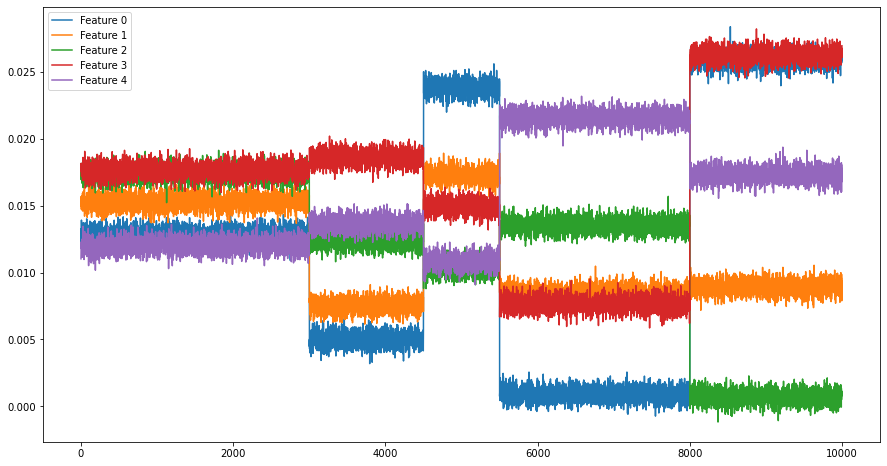

In [14]:
plot_costs(get_costs(), 10000)

In [15]:
costs_obj = get_costs()

In [16]:
costs_vector = []
for t in range(TIME_POINTS):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [17]:
costs_vector.shape

(10000, 5)

## Creating rewards

In [18]:
rewards = np.zeros((TIME_POINTS, N_ARMS))

In [19]:
slices = [
    slice(0,500),
    slice(500,1000),
    slice(1000,2000),
    slice(2000,4000),
    slice(4000,6000),
    slice(6000,8000),
    slice(8000,10000),
]

In [20]:
HIGH_REWARD_RANGE = [0.6, 0.99]
LOW_REWARD_RANGE = [0.01, 0.45]

In [21]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [22]:
# Here reward is stationary for given slice, arm.
# So piece-wise stationary for a given arm, not depending on context.

mean_rewards = np.zeros(rewards.shape)


for i, interval_slice in enumerate(slices):
    context_slice = contexts[interval_slice, :]
    slice_len = context_slice.shape[0]
    print(f"Slice {i}:")
    high_reward_arm = np.random.choice(N_ARMS)
    
    high_reward_arm = i % N_ARMS
    for arm in range(N_ARMS):

        # Use p from config (reward range is config)
        if arm == high_reward_arm:
            reward_range = HIGH_REWARD_RANGE
        else:
            reward_range = LOW_REWARD_RANGE
        
        p = np.random.uniform(reward_range[0], reward_range[1])

        # Sample rewards from the obtained distribution.
        slice_rewards = np.random.binomial(n=1, p=p, size=(slice_len,))
        rewards[interval_slice, arm] = slice_rewards
        
        # Check that thetas found by linear regression give estimation of expected reward close to
        # true expected reward. 
        
        # thetas found by solving linear regression problem
        linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)
        
        estimated_reward = np.mean(context_slice @ linreg_theta, axis=0)
        
        print(
            f"  Arm {arm}: p={np.mean(p):.2f}, mean reward={np.mean(slice_rewards):.2f}",
            f"  reward estimated by linear regression {estimated_reward:.2f}", 
        )
        
        # for visualization
        mean_rewards[interval_slice, arm] = np.ones(slice_rewards.shape) * np.mean(slice_rewards)

    

Slice 0:
  Arm 0: p=0.65, mean reward=0.64   reward estimated by linear regression 0.63
  Arm 1: p=0.25, mean reward=0.22   reward estimated by linear regression 0.22
  Arm 2: p=0.05, mean reward=0.06   reward estimated by linear regression 0.06
  Arm 3: p=0.39, mean reward=0.36   reward estimated by linear regression 0.35
  Arm 4: p=0.08, mean reward=0.07   reward estimated by linear regression 0.06
Slice 1:
  Arm 0: p=0.27, mean reward=0.28   reward estimated by linear regression 0.27
  Arm 1: p=0.70, mean reward=0.66   reward estimated by linear regression 0.65
  Arm 2: p=0.24, mean reward=0.22   reward estimated by linear regression 0.22
  Arm 3: p=0.30, mean reward=0.32   reward estimated by linear regression 0.31
  Arm 4: p=0.28, mean reward=0.26   reward estimated by linear regression 0.26
Slice 2:
  Arm 0: p=0.02, mean reward=0.02   reward estimated by linear regression 0.02
  Arm 1: p=0.11, mean reward=0.11   reward estimated by linear regression 0.10
  Arm 2: p=0.76, mean rew

/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_6173/492892621.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)


### Visualising rewards

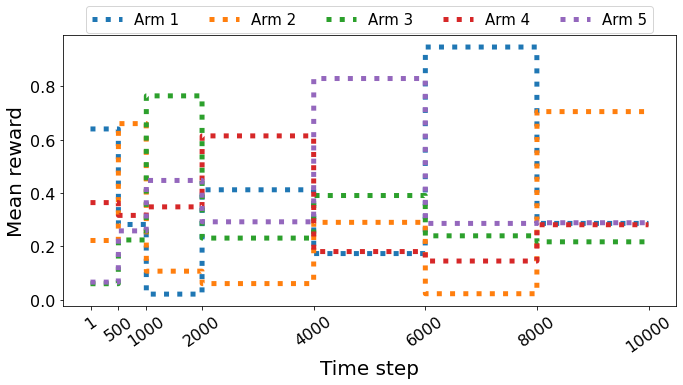

In [23]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(N_ARMS):
    ax.plot(mean_rewards[:, arm], label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    

    
extraticks = [1, 500, 1000]
plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel('Mean reward', fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


In [24]:
rewards.shape

(10000, 5)

In [25]:
costs_vector.shape

(10000, 5)

## Testing algorithms on synthetic data

In [26]:
%load_ext autoreload
%autoreload 2

import algorithms
import evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
NUM_OF_TRIALS = 10000
TUNING_NUM_TRIALS = 2000

### Random policy

#### Evaluation

In [28]:
p_random = algorithms.RandomPolicy()
gain_random = evaluation.evaluate_on_synthetic_data(
    p_random,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

Random policy
Total gain: 3441.0
	Total reward: 3441.0
	Total cost: 0
Execution time: 0.1s


### $\epsilon$-greedy

#### Tuning

In [29]:
egreedy_gains = {}

for eps in [0.001, 0.005, 0.01, 0.05, 0.08, 0.1, 0.2, 0.3]:
    egreedy = algorithms.EpsilonGreedy(epsilon=eps, n_arms=rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        contexts,
        rewards,
        costs_vector,
        stop_after=TUNING_NUM_TRIALS,
    )
    egreedy_gains[eps] = gain_egreedy

E-greedy(epsilon=0.001)
Total gain: 483.0
	Total reward: 483.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.005)
Total gain: 505.0
	Total reward: 505.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.01)
Total gain: 480.0
	Total reward: 480.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.05)
Total gain: 843.0
	Total reward: 843.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.08)
Total gain: 831.0
	Total reward: 831.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.1)
Total gain: 1015.0
	Total reward: 1015.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.2)
Total gain: 791.0
	Total reward: 791.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.3)
Total gain: 685.0
	Total reward: 685.0
	Total cost: 0
Execution time: 0.0s


In [30]:
last_gains = {k:v[-1] for k,v in egreedy_gains.items()}
best_eps = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]

In [31]:
best_eps

0.1

In [32]:
del egreedy_gains

#### Evaluation

In [33]:
egreedy = algorithms.EpsilonGreedy(epsilon=best_eps, n_arms=rewards.shape[1])

gain_egreedy = evaluation.evaluate_on_synthetic_data(
    egreedy,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

E-greedy(epsilon=0.01)
Total gain: 3392.0
	Total reward: 3392.0
	Total cost: 0
Execution time: 0.1s


### UCB1

#### Tuning

In [34]:
ucb_gains = {}

for alpha in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    ucb_alg = algorithms.UCB1(
        n_trials=TUNING_NUM_TRIALS,
        n_arms=rewards.shape[1],
        alpha=alpha,
    )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        contexts,
        rewards,
        costs_vector,
        stop_after=TUNING_NUM_TRIALS,
    )
    ucb_gains[alpha] = gain_ucb

UCB1 (α=0.01)
Total gain: 687.0
	Total reward: 687.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.05)
Total gain: 814.0
	Total reward: 814.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.1)
Total gain: 1176.0
	Total reward: 1176.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.15)
Total gain: 1104.0
	Total reward: 1104.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.2)
Total gain: 788.0
	Total reward: 788.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.25)
Total gain: 1215.0
	Total reward: 1215.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.3)
Total gain: 1241.0
	Total reward: 1241.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.35)
Total gain: 1308.0
	Total reward: 1308.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.4)
Total gain: 1202.0
	Total reward: 1202.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.45)
Total gain: 1359.0
	Total reward: 1359.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.5)
Total gain: 1254.0
	Total reward: 1254.0
	Total cost: 0
Execution time: 0.0s


In [35]:
last_gains = {k:v[-1] for k,v in ucb_gains.items()}
best_alpha_ucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]

In [36]:
best_alpha_ucb

0.45

In [37]:
del ucb_gains

#### Evaluation

In [38]:
ucb_alg = algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=rewards.shape[1],
        alpha=best_alpha_ucb,
    )

gain_ucb = evaluation.evaluate_on_synthetic_data(
    ucb_alg,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

UCB1 (α=0.45)
Total gain: 6140.0
	Total reward: 6140.0
	Total cost: 0
Execution time: 0.1s


### LinUCB

#### Tuning

In [39]:
linucb_gains = {}

for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    linucb = algorithms.LinUCB(
        context_dimension=contexts.shape[1],
        n_arms=rewards.shape[1],
        alpha=alpha,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        contexts,
        rewards,
        costs_vector,
        stop_after=TUNING_NUM_TRIALS,
    )
    linucb_gains[alpha] = gain_linucb

LinUCB (alpha=0.1)
Total gain: 975.6868709502943
	Total reward: 1126.0
	Total cost: 150.31312904970434
Execution time: 0.1s
LinUCB (alpha=0.2)
Total gain: 840.6868709502943
	Total reward: 991.0
	Total cost: 150.31312904970434
Execution time: 0.2s
LinUCB (alpha=0.3)
Total gain: 932.6868709502938
	Total reward: 1083.0
	Total cost: 150.31312904970434
Execution time: 0.1s
LinUCB (alpha=0.4)
Total gain: 1003.6868709502947
	Total reward: 1154.0
	Total cost: 150.31312904970434
Execution time: 0.1s
LinUCB (alpha=0.5)
Total gain: 813.6868709502941
	Total reward: 964.0
	Total cost: 150.31312904970434
Execution time: 0.1s
LinUCB (alpha=0.6)
Total gain: 949.6868709502945
	Total reward: 1100.0
	Total cost: 150.31312904970434
Execution time: 0.2s
LinUCB (alpha=0.7)
Total gain: 864.6868709502941
	Total reward: 1015.0
	Total cost: 150.31312904970434
Execution time: 0.2s


In [40]:
last_gains = {k:v[-1] for k,v in linucb_gains.items()}
best_alpha_linucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]

In [41]:
best_alpha_linucb

0.4

In [42]:
del linucb_gains

#### Evaluation

In [43]:
linucb = algorithms.LinUCB(
    context_dimension=contexts.shape[1],
    n_arms=rewards.shape[1],
    alpha=best_alpha_linucb,
)
gain_linucb = evaluation.evaluate_on_synthetic_data(
    linucb,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

LinUCB (alpha=0.4)
Total gain: 3904.458849085198
	Total reward: 4581.0
	Total cost: 676.5411509148023
Execution time: 0.7s


### PS-LinUCB

#### Tuning

In [44]:
ps_linucb_gains = {}

for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    for omega in [100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]:
        for delta in [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]:
            ps_linucb = algorithms.PSLinUCB(
                context_dimension=contexts.shape[1],
                n_arms=rewards.shape[1],
                alpha=alpha,
                omega=omega,
                delta=delta,
            )


            gain_pslinucb = evaluation.evaluate_on_synthetic_data(
                ps_linucb,
                contexts,
                rewards,
                costs_vector,
                stop_after=TUNING_NUM_TRIALS,
            )
            
            ps_linucb_gains[(alpha, omega, delta)] = gain_pslinucb

PSLinUCB (alpha=0.1, omega=100, delta=0.001)
Total gain: 729.686870950294
	Total reward: 880.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=100, delta=0.005)
Total gain: 729.686870950294
	Total reward: 880.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.1, omega=100, delta=0.01)
Total gain: 728.686870950294
	Total reward: 879.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=100, delta=0.03)
Total gain: 736.6868709502938
	Total reward: 887.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.1, omega=100, delta=0.05)
Total gain: 751.686870950294
	Total reward: 902.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.1, omega=100, delta=0.1)
Total gain: 1030.686870950295
	Total reward: 1181.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.1, omega=100, delta=0.15)
Total gain: 885.6868709502938
	Total reward: 1036.0
	Total cost: 150.3

PSLinUCB (alpha=0.1, omega=1500, delta=0.2)
Total gain: 975.6868709502943
	Total reward: 1126.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1750, delta=0.001)
Total gain: 975.6868709502943
	Total reward: 1126.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1750, delta=0.005)
Total gain: 975.6868709502943
	Total reward: 1126.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1750, delta=0.01)
Total gain: 975.6868709502943
	Total reward: 1126.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1750, delta=0.03)
Total gain: 975.6868709502943
	Total reward: 1126.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1750, delta=0.05)
Total gain: 975.6868709502943
	Total reward: 1126.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.1, omega=1750, delta=0.1)
Total gain: 975.6868709502943
	Total reward: 1126.0
	To

PSLinUCB (alpha=0.2, omega=1000, delta=0.2)
Total gain: 840.6868709502943
	Total reward: 991.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.2, omega=1250, delta=0.001)
Total gain: 840.6868709502943
	Total reward: 991.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1250, delta=0.005)
Total gain: 840.6868709502943
	Total reward: 991.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1250, delta=0.01)
Total gain: 840.6868709502943
	Total reward: 991.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.2, omega=1250, delta=0.03)
Total gain: 840.6868709502943
	Total reward: 991.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.2, omega=1250, delta=0.05)
Total gain: 840.6868709502943
	Total reward: 991.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1250, delta=0.1)
Total gain: 840.6868709502943
	Total reward: 991.0
	Total cos

PSLinUCB (alpha=0.3, omega=500, delta=0.2)
Total gain: 932.6868709502938
	Total reward: 1083.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=750, delta=0.001)
Total gain: 932.6868709502938
	Total reward: 1083.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=750, delta=0.005)
Total gain: 932.6868709502938
	Total reward: 1083.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=750, delta=0.01)
Total gain: 932.6868709502938
	Total reward: 1083.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=750, delta=0.03)
Total gain: 932.6868709502938
	Total reward: 1083.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=750, delta=0.05)
Total gain: 932.6868709502938
	Total reward: 1083.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=750, delta=0.1)
Total gain: 932.6868709502938
	Total reward: 1083.0
	Total cos

PSLinUCB (alpha=0.4, omega=100, delta=0.15)
Total gain: 1034.686870950295
	Total reward: 1185.0
	Total cost: 150.31312904970434
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=100, delta=0.2)
Total gain: 1039.6868709502953
	Total reward: 1190.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.4, omega=250, delta=0.001)
Total gain: 987.6868709502945
	Total reward: 1138.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=250, delta=0.005)
Total gain: 987.6868709502945
	Total reward: 1138.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.4, omega=250, delta=0.01)
Total gain: 987.6868709502945
	Total reward: 1138.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.4, omega=250, delta=0.03)
Total gain: 987.6868709502945
	Total reward: 1138.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=250, delta=0.05)
Total gain: 987.6868709502945
	Total reward: 1138.0
	Total c

PSLinUCB (alpha=0.4, omega=1750, delta=0.1)
Total gain: 1003.6868709502947
	Total reward: 1154.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.4, omega=1750, delta=0.15)
Total gain: 1003.6868709502947
	Total reward: 1154.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.4, omega=1750, delta=0.2)
Total gain: 1003.6868709502947
	Total reward: 1154.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.4, omega=2000, delta=0.001)
Total gain: 1003.6868709502947
	Total reward: 1154.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=2000, delta=0.005)
Total gain: 1003.6868709502947
	Total reward: 1154.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=2000, delta=0.01)
Total gain: 1003.6868709502947
	Total reward: 1154.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.4, omega=2000, delta=0.03)
Total gain: 1003.6868709502947
	Total reward: 115

PSLinUCB (alpha=0.5, omega=1250, delta=0.05)
Total gain: 813.6868709502941
	Total reward: 964.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1250, delta=0.1)
Total gain: 813.6868709502941
	Total reward: 964.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1250, delta=0.15)
Total gain: 813.6868709502941
	Total reward: 964.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1250, delta=0.2)
Total gain: 813.6868709502941
	Total reward: 964.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1500, delta=0.001)
Total gain: 813.6868709502941
	Total reward: 964.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1500, delta=0.005)
Total gain: 813.6868709502941
	Total reward: 964.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.5, omega=1500, delta=0.01)
Total gain: 813.6868709502941
	Total reward: 964.0
	Total cos

PSLinUCB (alpha=0.6, omega=750, delta=0.03)
Total gain: 949.6868709502945
	Total reward: 1100.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=750, delta=0.05)
Total gain: 949.6868709502945
	Total reward: 1100.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=750, delta=0.1)
Total gain: 949.6868709502945
	Total reward: 1100.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=750, delta=0.15)
Total gain: 949.6868709502945
	Total reward: 1100.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=750, delta=0.2)
Total gain: 949.6868709502945
	Total reward: 1100.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=1000, delta=0.001)
Total gain: 949.6868709502945
	Total reward: 1100.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=1000, delta=0.005)
Total gain: 949.6868709502945
	Total reward: 1100.0
	Total c

PSLinUCB (alpha=0.7, omega=250, delta=0.03)
Total gain: 1050.6868709502962
	Total reward: 1201.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=250, delta=0.05)
Total gain: 1050.6868709502962
	Total reward: 1201.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=250, delta=0.1)
Total gain: 1049.6868709502962
	Total reward: 1200.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=250, delta=0.15)
Total gain: 1049.6868709502962
	Total reward: 1200.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=250, delta=0.2)
Total gain: 1041.6868709502953
	Total reward: 1192.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=500, delta=0.001)
Total gain: 864.6868709502941
	Total reward: 1015.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=500, delta=0.005)
Total gain: 864.6868709502941
	Total reward: 1015.0
	Tota

PSLinUCB (alpha=0.7, omega=2000, delta=0.03)
Total gain: 864.6868709502941
	Total reward: 1015.0
	Total cost: 150.31312904970434
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=2000, delta=0.05)
Total gain: 864.6868709502941
	Total reward: 1015.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=2000, delta=0.1)
Total gain: 864.6868709502941
	Total reward: 1015.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=2000, delta=0.15)
Total gain: 864.6868709502941
	Total reward: 1015.0
	Total cost: 150.31312904970434
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=2000, delta=0.2)
Total gain: 864.6868709502941
	Total reward: 1015.0
	Total cost: 150.31312904970434
Execution time: 0.1s


In [45]:
last_gains = {k:v[-1] for k,v in ps_linucb_gains.items()}
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]

In [46]:
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb

(0.6, 100, 0.05)

In [47]:
del ps_linucb_gains

#### Evaluation

In [48]:
ps_linucb = algorithms.PSLinUCB(
    context_dimension=contexts.shape[1],
    n_arms=rewards.shape[1],
    alpha=best_alpha_ps_linucb,
    omega=best_omega_ps_linucb,
    delta=best_delta_ps_linucb,
)


gain_pslinucb = evaluation.evaluate_on_synthetic_data(
    ps_linucb,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)
change_points = ps_linucb.change_points

PSLinUCB (alpha=0.6, omega=100, delta=0.05)
Total gain: 6088.45884908521
	Total reward: 6765.0
	Total cost: 676.5411509148023
Execution time: 0.9s


### SimOOS

#### Tuning

In [49]:
simoos_gains = {}

for beta in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]:
    for delta in [0.005, 0.01, 0.03, 0.05, 0.08, 0.1, 0.2]:
        s = time.time()
        p_simoos = algorithms.SimOOSAlgorithm(
            all_contexts=contexts[:TUNING_NUM_TRIALS], 
            number_of_actions=rewards.shape[1],
            max_no_red_context=contexts.shape[1],
            beta_SimOOS=beta,
            delta_SimOOS=delta,
        )
        print(f"Took {time.time() - s} seconds")

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = time.time()
            gain_simoos = evaluation.evaluate_on_synthetic_data(
                p_simoos,
                contexts[:TUNING_NUM_TRIALS],
                rewards[:TUNING_NUM_TRIALS],
                costs_vector[:TUNING_NUM_TRIALS],
                stop_after=TUNING_NUM_TRIALS,
            )
            print(f"Took {time.time() - s} seconds")

        simoos_gains[(beta, delta)] = gain_simoos

Took 0.0021622180938720703 seconds
Trial 0, time 2022-03-31 10:33:49.829831
Trial 500, time 2022-03-31 10:33:55.815414
Trial 1000, time 2022-03-31 10:34:02.842326
Trial 1500, time 2022-03-31 10:34:05.790829
SimOOS (beta=0.1, delta=0.005)
Total gain: 788.1315066913369
	Total reward: 803.0
	Total cost: 14.86849330866226
Execution time: 18.7s
Took 18.697144746780396 seconds
Took 0.002232789993286133 seconds
Trial 0, time 2022-03-31 10:34:08.529228
Trial 500, time 2022-03-31 10:34:30.312312
Trial 1000, time 2022-03-31 10:34:33.535761
Trial 1500, time 2022-03-31 10:34:36.780811
SimOOS (beta=0.1, delta=0.01)
Total gain: 738.3874005833226
	Total reward: 798.0
	Total cost: 59.61259941667684
Execution time: 30.5s
Took 30.531404972076416 seconds
Took 0.006073713302612305 seconds
Trial 0, time 2022-03-31 10:34:39.066916
Trial 500, time 2022-03-31 10:34:44.930450
Trial 1000, time 2022-03-31 10:34:46.121181
Trial 1500, time 2022-03-31 10:34:53.502033
SimOOS (beta=0.1, delta=0.03)
Total gain: 1029.4

Trial 500, time 2022-03-31 10:46:17.273268
Trial 1000, time 2022-03-31 10:46:23.596594
Trial 1500, time 2022-03-31 10:46:28.085360
SimOOS (beta=0.4, delta=0.01)
Total gain: 981.5225383355364
	Total reward: 1001.0
	Total cost: 19.47746166446263
Execution time: 23.5s
Took 23.52061700820923 seconds
Took 0.012897014617919922 seconds
Trial 0, time 2022-03-31 10:46:30.311851
Trial 500, time 2022-03-31 10:46:55.885658
Trial 1000, time 2022-03-31 10:46:59.661723
Trial 1500, time 2022-03-31 10:47:02.784805
SimOOS (beta=0.4, delta=0.03)
Total gain: 710.5516445198311
	Total reward: 770.0
	Total cost: 59.44835548016787
Execution time: 35.5s
Took 35.461668968200684 seconds
Took 0.003420114517211914 seconds
Trial 0, time 2022-03-31 10:47:05.777060
Trial 500, time 2022-03-31 10:47:55.590376
Trial 1000, time 2022-03-31 10:48:16.547273
Trial 1500, time 2022-03-31 10:48:25.180135
SimOOS (beta=0.4, delta=0.05)
Total gain: 585.5034314135527
	Total reward: 668.0
	Total cost: 82.49656858644796
Execution tim

Trial 1000, time 2022-03-31 11:11:57.717791
Trial 1500, time 2022-03-31 11:12:01.798052
SimOOS (beta=0.7, delta=0.03)
Total gain: 710.5516445198311
	Total reward: 770.0
	Total cost: 59.44835548016787
Execution time: 45.9s
Took 45.947072982788086 seconds
Took 0.005323171615600586 seconds
Trial 0, time 2022-03-31 11:12:05.396542
Trial 500, time 2022-03-31 11:13:09.509531
Trial 1000, time 2022-03-31 11:13:24.265939
Trial 1500, time 2022-03-31 11:13:32.772294
SimOOS (beta=0.7, delta=0.05)
Total gain: 515.2992415094103
	Total reward: 609.0
	Total cost: 93.70075849059027
Execution time: 1.6m
Took 93.21830701828003 seconds
Took 0.0073642730712890625 seconds
Trial 0, time 2022-03-31 11:13:38.622305
Trial 500, time 2022-03-31 11:13:51.977830
Trial 1000, time 2022-03-31 11:14:00.597784
Trial 1500, time 2022-03-31 11:14:06.560823
SimOOS (beta=0.7, delta=0.08)
Total gain: 966.5225383355364
	Total reward: 986.0
	Total cost: 19.47746166446263
Execution time: 30.8s
Took 30.8222873210907 seconds
Took 

In [50]:
last_gains = {k:v[-1] for k,v in simoos_gains.items()}
best_beta_simoos, best_delta_simoos  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]

In [51]:
best_beta_simoos, best_delta_simoos

(0.6, 0.2)

In [52]:
del simoos_gains

#### Evaluation

In [53]:
s = time.time()
p_simoos = algorithms.SimOOSAlgorithm(
    all_contexts=contexts, 
    number_of_actions=rewards.shape[1],
    max_no_red_context=contexts.shape[1],
    beta_SimOOS=best_beta_simoos,
    delta_SimOOS=best_delta_simoos,
)
print(f"Took {time.time() - s} seconds")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_simoos = evaluation.evaluate_on_synthetic_data(
        p_simoos,
        contexts[:NUM_OF_TRIALS],
        rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


Took 0.01077127456665039 seconds
Trial 0, time 2022-03-31 11:33:48.244285
Trial 500, time 2022-03-31 11:34:01.881686
Trial 1000, time 2022-03-31 11:34:11.870548
Trial 1500, time 2022-03-31 11:34:16.888417
Trial 2000, time 2022-03-31 11:34:21.285071
Trial 2500, time 2022-03-31 11:34:26.506743
Trial 3000, time 2022-03-31 11:34:29.624721
Trial 3500, time 2022-03-31 11:34:31.281848
Trial 4000, time 2022-03-31 11:34:37.196050
Trial 4500, time 2022-03-31 11:34:43.450637
Trial 5000, time 2022-03-31 11:34:44.831638
Trial 5500, time 2022-03-31 11:34:46.393457
Trial 6000, time 2022-03-31 11:34:48.056971
Trial 6500, time 2022-03-31 11:34:49.517933
Trial 7000, time 2022-03-31 11:34:50.668931
Trial 7500, time 2022-03-31 11:34:51.990517
Trial 8000, time 2022-03-31 11:34:53.001487
Trial 8500, time 2022-03-31 11:34:53.944966
Trial 9000, time 2022-03-31 11:34:54.996071
Trial 9500, time 2022-03-31 11:34:56.124173
SimOOS (beta=0.6, delta=0.2)
Total gain: 4572.451247077921
	Total reward: 4686.0
	Total cos

### Algorithm1

#### Tuning

In [54]:
alg1_gains = {}

for beta in [1.0]:
    for delta in  [0.1, 0.15]:
        for window in [100, 500, 1000, 1250]:
            s = time.time()
            p_alg1 = algorithms.Algorithm1(
                all_contexts=contexts[:TUNING_NUM_TRIALS], 
                number_of_actions=rewards.shape[1],
                max_no_red_context=contexts.shape[1],
                beta=beta,
                delta=delta,
                window_length=window,
            )
            print(f"Took {time.time() - s} seconds")

            import warnings
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                s = time.time()
                gain_alg1 = evaluation.evaluate_on_synthetic_data(
                    p_alg1,
                    contexts[:TUNING_NUM_TRIALS],
                    rewards[:TUNING_NUM_TRIALS],
                    costs_vector[:TUNING_NUM_TRIALS],
                    stop_after=TUNING_NUM_TRIALS,
                )
                print(f"Took {time.time() - s} seconds")
            alg1_gains[(beta, delta, window)] = gain_alg1
            

Took 0.006611347198486328 seconds
Round 500, time 2022-03-31 11:40:10.277296
Round 1000, time 2022-03-31 11:46:29.857435
Round 1500, time 2022-03-31 11:52:54.900167
Algorithm1 (beta=1.0, delta=0.1, w=100)
Total gain: 1136.8014976473287
	Total reward: 1138.0
	Total cost: 1.1985023526712129
Execution time: 24.4m
Took 1465.4674110412598 seconds
Took 0.016005992889404297 seconds
Round 500, time 2022-03-31 12:12:56.989577
Round 1000, time 2022-03-31 12:39:06.936641
Round 1500, time 2022-03-31 13:05:24.658778
Algorithm1 (beta=1.0, delta=0.1, w=500)
Total gain: 1173.8014976473287
	Total reward: 1175.0
	Total cost: 1.1985023526712129
Execution time: 92.9m
Took 5576.352914810181 seconds
Took 0.09359908103942871 seconds
Round 500, time 2022-03-31 13:47:00.031409
Round 1000, time 2022-03-31 14:29:18.610802
Round 1500, time 2022-03-31 15:28:40.659402
Algorithm1 (beta=1.0, delta=0.1, w=1000)
Total gain: 1254.8014976473287
	Total reward: 1256.0
	Total cost: 1.1985023526712129
Execution time: 172.9m


In [55]:
last_gains = {k:v[-1] for k,v in alg1_gains.items()}
best_beta_alg1, best_delta_alg1, best_window_alg1  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]

In [56]:
sorted(
    last_gains.items(), key=lambda x: x[1]
)

[((1.0, 0.1, 1250), 954.0641057162444),
 ((1.0, 0.15, 100), 1124.4614453003824),
 ((1.0, 0.1, 100), 1136.8014976473287),
 ((1.0, 0.1, 500), 1173.8014976473287),
 ((1.0, 0.15, 500), 1194.8014976473287),
 ((1.0, 0.1, 1000), 1254.8014976473287),
 ((1.0, 0.15, 1000), 1265.8014976473287),
 ((1.0, 0.15, 1250), 1269.8014976473287)]

In [57]:
best_beta_alg1, best_delta_alg1, best_window_alg1

(1.0, 0.15, 1250)

In [58]:
del alg1_gains

#### Evaluation

In [59]:
s = time.time()
p_alg1 = algorithms.Algorithm1(
    all_contexts=contexts, 
    number_of_actions=rewards.shape[1],
    max_no_red_context=contexts.shape[1],
    beta=best_beta_alg1,
    delta=best_delta_alg1,
    window_length=best_window_alg1,
)
print(f"Took {time.time() - s} seconds")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_alg1 = evaluation.evaluate_on_synthetic_data(
        p_alg1,
        contexts[:NUM_OF_TRIALS],
        rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


Took 0.06099700927734375 seconds
Round 500, time 2022-04-01 00:38:47.044128
Round 1000, time 2022-04-01 01:00:08.238193
Round 1500, time 2022-04-01 01:35:06.877760
Round 2000, time 2022-04-01 02:09:09.623597
Round 2500, time 2022-04-01 02:52:15.844799
Round 3000, time 2022-04-01 03:36:31.420190
Round 3500, time 2022-04-01 04:12:10.158169
Round 4000, time 2022-04-01 04:55:42.188316
Round 4500, time 2022-04-01 05:38:03.417023
Round 5000, time 2022-04-01 06:05:53.135365
Round 5500, time 2022-04-01 06:42:40.887022
Round 6000, time 2022-04-01 07:17:19.522887
Round 6500, time 2022-04-01 08:01:29.939757
Round 7000, time 2022-04-01 08:42:45.040431
Round 7500, time 2022-04-01 09:25:08.147637
Round 8000, time 2022-04-01 10:08:50.633968
Round 8500, time 2022-04-01 10:47:19.253110
Round 9000, time 2022-04-01 11:37:03.179641
Round 9500, time 2022-04-01 15:47:29.863066
Algorithm1 (beta=1.0, delta=0.15, w=1250)
Total gain: 6855.772411071683
	Total reward: 6857.0
	Total cost: 1.227588928316863
Executi

### Plot cumulative gain

In [60]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(16, 8));
        
    max_vline=0
    
    for label, gain in gain_dict.items():
        ax.plot(gain, label=label)
        max_vline=max(max_vline, max(gain))
    ax.set_xlabel('Trial')
    ax.set_ylabel('Cumulative gain')
    ax.set_title('Evaluation on synthetic data')
    
#     ax.vlines(change_points, 0, max_vline, label='change points', color='pink')

    plt.legend();
    plt.show();

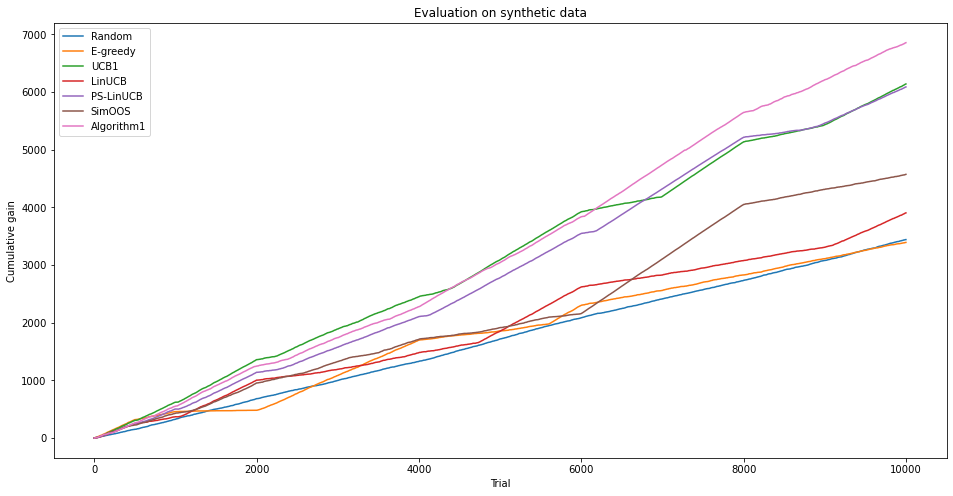

In [61]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)
